In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

In [3]:
train = pd.read_pickle('../data/train_1628features.pkl')
test = pd.read_pickle('../data/test_1628features.pkl')
y_train = pd.read_csv('../data/y_train.csv', index_col = 'key_value')

In [4]:
def cross_validation_lightgbm(train, y_train, test):
    folds = [train.index[t] for t, v in KFold(5).split(train)]
    test_probs = []
    train_probs = []
    fi = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.loc[idx]
        yt = y_train.loc[Xt.index].target

        Xv = train.drop(Xt.index)
        yv = y_train.loc[Xv.index].target

        learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, colsample_bytree=0.8,
                       subsample=0.8, max_bin=200, learning_rate=0.1, random_state=42)

        learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                    eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
        test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))
        gc.collect()
    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    train_probs = pd.concat(train_probs)
    fi = pd.concat(fi, axis=1).mean(axis=1)
    print("*" * 21)
    print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
    print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))
    return fi, train_probs, test_probs

In [10]:
fi_lightgbm, train_probs_lightgbm, test_probs_lightgbm = cross_validation_lightgbm(train,
                                                                                   y_train,
                                                                                   test)

********** 0 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.865738	training's binary_logloss: 0.284699	valid_1's auc: 0.851391	valid_1's binary_logloss: 0.296529
[200]	training's auc: 0.880347	training's binary_logloss: 0.272856	valid_1's auc: 0.854319	valid_1's binary_logloss: 0.29402
Early stopping, best iteration is:
[244]	training's auc: 0.885404	training's binary_logloss: 0.268735	valid_1's auc: 0.854716	valid_1's binary_logloss: 0.293637
********** 1 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.865794	training's binary_logloss: 0.284651	valid_1's auc: 0.850808	valid_1's binary_logloss: 0.296588
[200]	training's auc: 0.880467	training's binary_logloss: 0.272648	valid_1's auc: 0.854028	valid_1's binary_logloss: 0.293849
Early stopping, best iteration is:
[265]	training's auc: 0.887901	training's binary_logloss: 0.266562	valid_1's auc: 0.854848	valid_1's binary_logloss: 0.293288
*****

In [15]:
fi_lightgbm.to_pickle('fi_lightgbm.pkl')
train_probs_lightgbm.to_pickle('train_probs_lightgbm.pkl')
test_probs_lightgbm.to_pickle('test_probs_lightgbm.pkl')

In [6]:
def cross_validation_catboost(train, y_train, test):
    folds = [train.index[t] for t, v in KFold(5).split(train)]
    test_probs = []
    train_probs = []
    fi = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.loc[idx]
        yt = y_train.loc[Xt.index]

        Xv = train.drop(Xt.index)
        yv = y_train.loc[Xv.index]

        learner = CatBoostClassifier(n_estimators=1000, eval_metric = 'AUC', max_depth=6, random_state=42)

        learner.fit(Xt, yt,  early_stopping_rounds=10, 
                    eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
        test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))
        gc.collect()
    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    train_probs = pd.concat(train_probs)
    fi = pd.concat(fi, axis=1).mean(axis=1)
    print("*" * 21)
    print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
    print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))
    return fi, train_probs, test_probs

In [8]:
fi_catboost, train_probs_catboost, test_probs_catboost = cross_validation_catboost(train,
                                                                                   y_train,
                                                                                   test)

********** 0 **********
Learning rate set to 0.128212
0:	test: 0.7126292	test1: 0.7167120	best: 0.7167120 (0)	total: 1.08s	remaining: 17m 59s
100:	test: 0.8472001	test1: 0.8430424	best: 0.8430424 (100)	total: 1m 43s	remaining: 15m 17s
200:	test: 0.8579057	test1: 0.8487810	best: 0.8487810 (200)	total: 3m 19s	remaining: 13m 13s
300:	test: 0.8647767	test1: 0.8505776	best: 0.8506045 (298)	total: 4m 52s	remaining: 11m 18s
400:	test: 0.8703525	test1: 0.8516663	best: 0.8516825 (399)	total: 6m 23s	remaining: 9m 32s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.8519151207
bestIteration = 439

Shrink model to first 440 iterations.
********** 1 **********
Learning rate set to 0.128212
0:	test: 0.7252973	test1: 0.7240042	best: 0.7240042 (0)	total: 901ms	remaining: 15m
100:	test: 0.8475386	test1: 0.8432957	best: 0.8432957 (100)	total: 1m 42s	remaining: 15m 15s
200:	test: 0.8577914	test1: 0.8485744	best: 0.8485744 (200)	total: 3m 18s	remaining: 13m 8s
300:	test: 0.8647701	test1

In [16]:
fi_catboost.to_pickle('fi_catboost.pkl')
train_probs_catboost.to_pickle('train_probs_catboost.pkl')
test_probs_catboost.to_pickle('test_probs_catboost.pkl')

In [5]:
def cross_validation_lightgbm_cf(train, y_train, test):
    var_categ = [c for c in train.columns if 'mode' in c]
    for c in var_categ:
        train[c] = train[c].astype('category')
        test[c] = test[c].astype('category')

    folds = [train.index[t] for t, v in KFold(5).split(train)]
    test_probs = []
    train_probs = []
    fi = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.loc[idx]
        yt = y_train.loc[Xt.index].target

        Xv = train.drop(Xt.index)
        yv = y_train.loc[Xv.index].target

        learner = LGBMClassifier(n_estimators=1000, boosting_type='gbdt',min_child_samples=1500, colsample_bytree=0.8,
                       subsample=0.8, max_bin=200, learning_rate=0.1, random_state = 42)

        learner.fit(Xt, yt,  early_stopping_rounds=10, eval_metric="auc",
                    eval_set=[(Xt, yt), (Xv, yv)], verbose=100)
        test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))
        gc.collect()
    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    train_probs = pd.concat(train_probs)
    fi = pd.concat(fi, axis=1).mean(axis=1)
    print("*" * 21)
    print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
    print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))]))
    return fi, train_probs, test_probs

In [ ]:
def get_feature_selection(fi):
    zero_importance = fi[fi==0]
    aux = fi[fi>0].sort_values(ascending=False)
    keep_columns = []
    count = 0
    for feature,values in zip(aux.index, aux.values):
        count+=values
        if count<=0.80:
            keep_columns.append(feature)
            
    print(f'total de variables : {len(fi)}')
    print(f'variables con importancia acumulada al 80% : {len(keep_columns)}')
    print(f'variables con zero importancia : {len(zero_importance)}')
    return keep_columns, zero_importance
keep_columns, zero_importance = get_feature_selection(fi_lightgbm)

In [7]:
fi_lightgbm_cf, train_probs_lightgbm_cf, test_probs_lightgbm_cf = cross_validation_lightgbm_cf(train[keep_columns],
                                                                                               y_train, 
                                                                                               test[keep_columns])

********** 0 **********


C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\usuario\anaconda3\envs\venv_datathon\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.874593	training's binary_logloss: 0.279071	valid_1's auc: 0.850158	valid_1's binary_logloss: 0.297041
[200]	training's auc: 0.891306	training's binary_logloss: 0.264697	valid_1's auc: 0.852824	valid_1's binary_logloss: 0.294651
Early stopping, best iteration is:
[211]	training's auc: 0.892724	training's binary_logloss: 0.263451	valid_1's auc: 0.852935	valid_1's binary_logloss: 0.294541
********** 1 **********
Training until validation scores don't improve for 10 rounds
[100]	training's auc: 0.874742	training's binary_logloss: 0.278899	valid_1's auc: 0.848628	valid_1's binary_logloss: 0.297857
[200]	training's auc: 0.891744	training's binary_logloss: 0.264378	valid_1's auc: 0.851151	valid_1's binary_logloss: 0.29568
Early stopping, best iteration is:
[257]	training's auc: 0.898835	training's binary_logloss: 0.25813	valid_1's auc: 0.851631	valid_1's binary_logloss: 0.295309
********** 2 **********
Traini

In [18]:
fi_lightgbm_cf.to_pickle('fi_lightgbm_cf.pkl')
train_probs_lightgbm_cf.to_pickle('train_probs_lightgbm_cf.pkl')
test_probs_lightgbm_cf.to_pickle('test_probs_lightgbm_cf.pkl')

In [9]:
def cross_validation_gbc(train, y_train, test):        
    folds = [train.index[t] for t, v in KFold(5).split(train)]
    test_probs = []
    train_probs = []
    fi = []
    for i, idx in enumerate(folds):
        print("*"*10, i, "*"*10)
        Xt = train.loc[idx]
        yt = y_train.loc[Xt.index].target

        Xv = train.drop(Xt.index)
        yv = y_train.loc[Xv.index].target

        learner = GradientBoostingClassifier(n_estimators=500, learning_rate=0.3, subsample=0.8,
                                             max_depth=5, verbose=1, max_features=0.82, random_state=42,
                                             n_iter_no_change = 10, tol=0.01, validation_fraction = 0.2)

        learner.fit(Xt, yt)        
        test_probs.append(pd.Series(learner.predict_proba(test)[:, -1], index=test.index, name="fold_" + str(i)))
        train_probs.append(pd.Series(learner.predict_proba(Xv)[:, -1], index=Xv.index, name="probs"))
        fi.append(pd.Series(learner.feature_importances_ / learner.feature_importances_.sum(), index=Xt.columns))
        print('roc_auc_estimado de : ' + str(roc_auc_score(yv, pd.Series(learner.predict_proba(Xv)[:, -1]))))    

    test_probs = pd.concat(test_probs, axis=1).mean(axis=1)
    train_probs = pd.concat(train_probs)
    fi = pd.concat(fi, axis=1).mean(axis=1)
    print("*" * 21)
    print("roc auc estimado: ", roc_auc_score(y_train, train_probs.loc[y_train.index]))
    print("roc auc varianza: ", np.std([roc_auc_score(y_train.loc[folds[i]], train_probs.iloc[folds[i]]) for i in range(len(folds))])) 
    return fi, train_probs, test_probs    

In [10]:
var_categ = [c for c in train.columns if 'mode' in c]
for c in var_categ:
    train[c] = train[c].astype('float16')
    test[c] = test[c].astype('float16')

var_categ = [i for i in train.columns if 'mode' in i]
var_cuanti_std = [i for i in train.columns if 'std'  in i]
var_cuanti_unique = [i for i in train.columns if 'unique' in i]
var_cuanti_other = set(train.columns).difference(var_categ+var_cuanti_std+var_cuanti_unique)

###### imputacion tradicional
for i in var_cuanti_std:
    train[i] = train[i].fillna(0)
    test[i] = test[i].fillna(0)  
    
for i in var_cuanti_unique:
    train[i] = train[i].fillna(0)
    test[i] = test[i].fillna(0)
    
for i in var_cuanti_other:
    train[i] = train[i].fillna(train[i].median())
    test[i] = test[i].fillna(train[i].median())    
for i in var_categ:
    train[i] = train[i].fillna(train[i].value_counts().index[0])
    test[i] = test[i].fillna(train[i].value_counts().index[0]) 

In [13]:
fi_gbc, train_probs_gbc, test_probs_gbc = cross_validation_gbc(train,
                                                               y_train,
                                                               test)

********** 0 **********
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7721           0.0961         1031.20m
         2           0.7354           0.0343         1031.47m
         3           0.7019           0.0298         1049.06m
         4           0.6876           0.0161         1054.33m
         5           0.6732           0.0137         1054.32m
         6           0.6604           0.0111         1052.79m
         7           0.6533           0.0048         1047.32m
         8           0.6483           0.0070         1076.93m
         9           0.6439           0.0040         1149.38m
        10           0.6362           0.0037         1209.06m
        20           0.6065           0.0010         1122.85m
roc_auc_estimado de : 0.8342619884903911
********** 1 **********
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.7733           0.1018          512.17m
         2           0.7318           0.0

In [14]:
fi_gbc.to_pickle('fi_gbc.pkl')
train_probs_gbc.to_pickle('train_probs_gbc.pkl')
test_probs_gbc.to_pickle('test_probs_gbc.pkl')

## Plot - Features Importances

In [45]:
fi_lightgbm = pd.read_pickle('fi_lightgbm.pkl')
fi_lightgbm_cf = pd.read_pickle('fi_lightgbm_cf.pkl')
fi_catboost = pd.read_pickle('fi_catboost.pkl')
fi_gbc = pd.read_pickle('fi_gbc.pkl')
features_importances = pd.concat([fi_lightgbm, fi_lightgbm_cf, fi_catboost, fi_gbc], axis=1)
features_importances.columns = ['fi_lightgbm', 'fi_lightgbm_cf', 'fi_catboost', 'fi_gbc']
features_importances['mean_fi'] = features_importances.mean(axis=1)
features_importances['std_fi'] = features_importances.std(axis=1)
features_importances

,fi_lightgbm,fi_lightgbm_cf,fi_catboost,fi_gbc,mean_fi,std_fi
edad,0.008190,0.007589,0.011209,0.005143,0.008033,0.002160
ubigeo_mode,0.006485,0.046752,0.001590,0.000179,0.013752,0.019196
sexo_0,0.005105,0.005298,0.009658,0.003937,0.006000,0.002176
PRODUCTO_1_saldoMean_ult1meses,0.004811,0.005070,0.004724,0.002714,0.004330,0.000941
PRODUCTO_1_saldoMax_ult1meses,0.004633,0.004386,0.003062,0.002115,0.003549,0.001021
...,...,...,...,...,...,...
PRODUCTO_5_saldoMax_ult3meses,0.000180,0.000057,0.000000,0.000000,0.000059,0.000073
cod_instit_financiera_56_saldoMean_ult3meses,0.000252,0.000061,0.000058,0.000000,0.000093,0.000095
cod_instit_financiera_18_saldoMin_ult1meses,0.000110,0.000000,0.000015,0.000000,0.000031,0.000046
cod_instit_financiera_11_saldoStd_ult3meses,0.000254,0.000000,0.000199,0.000000,0.000113,0.000115


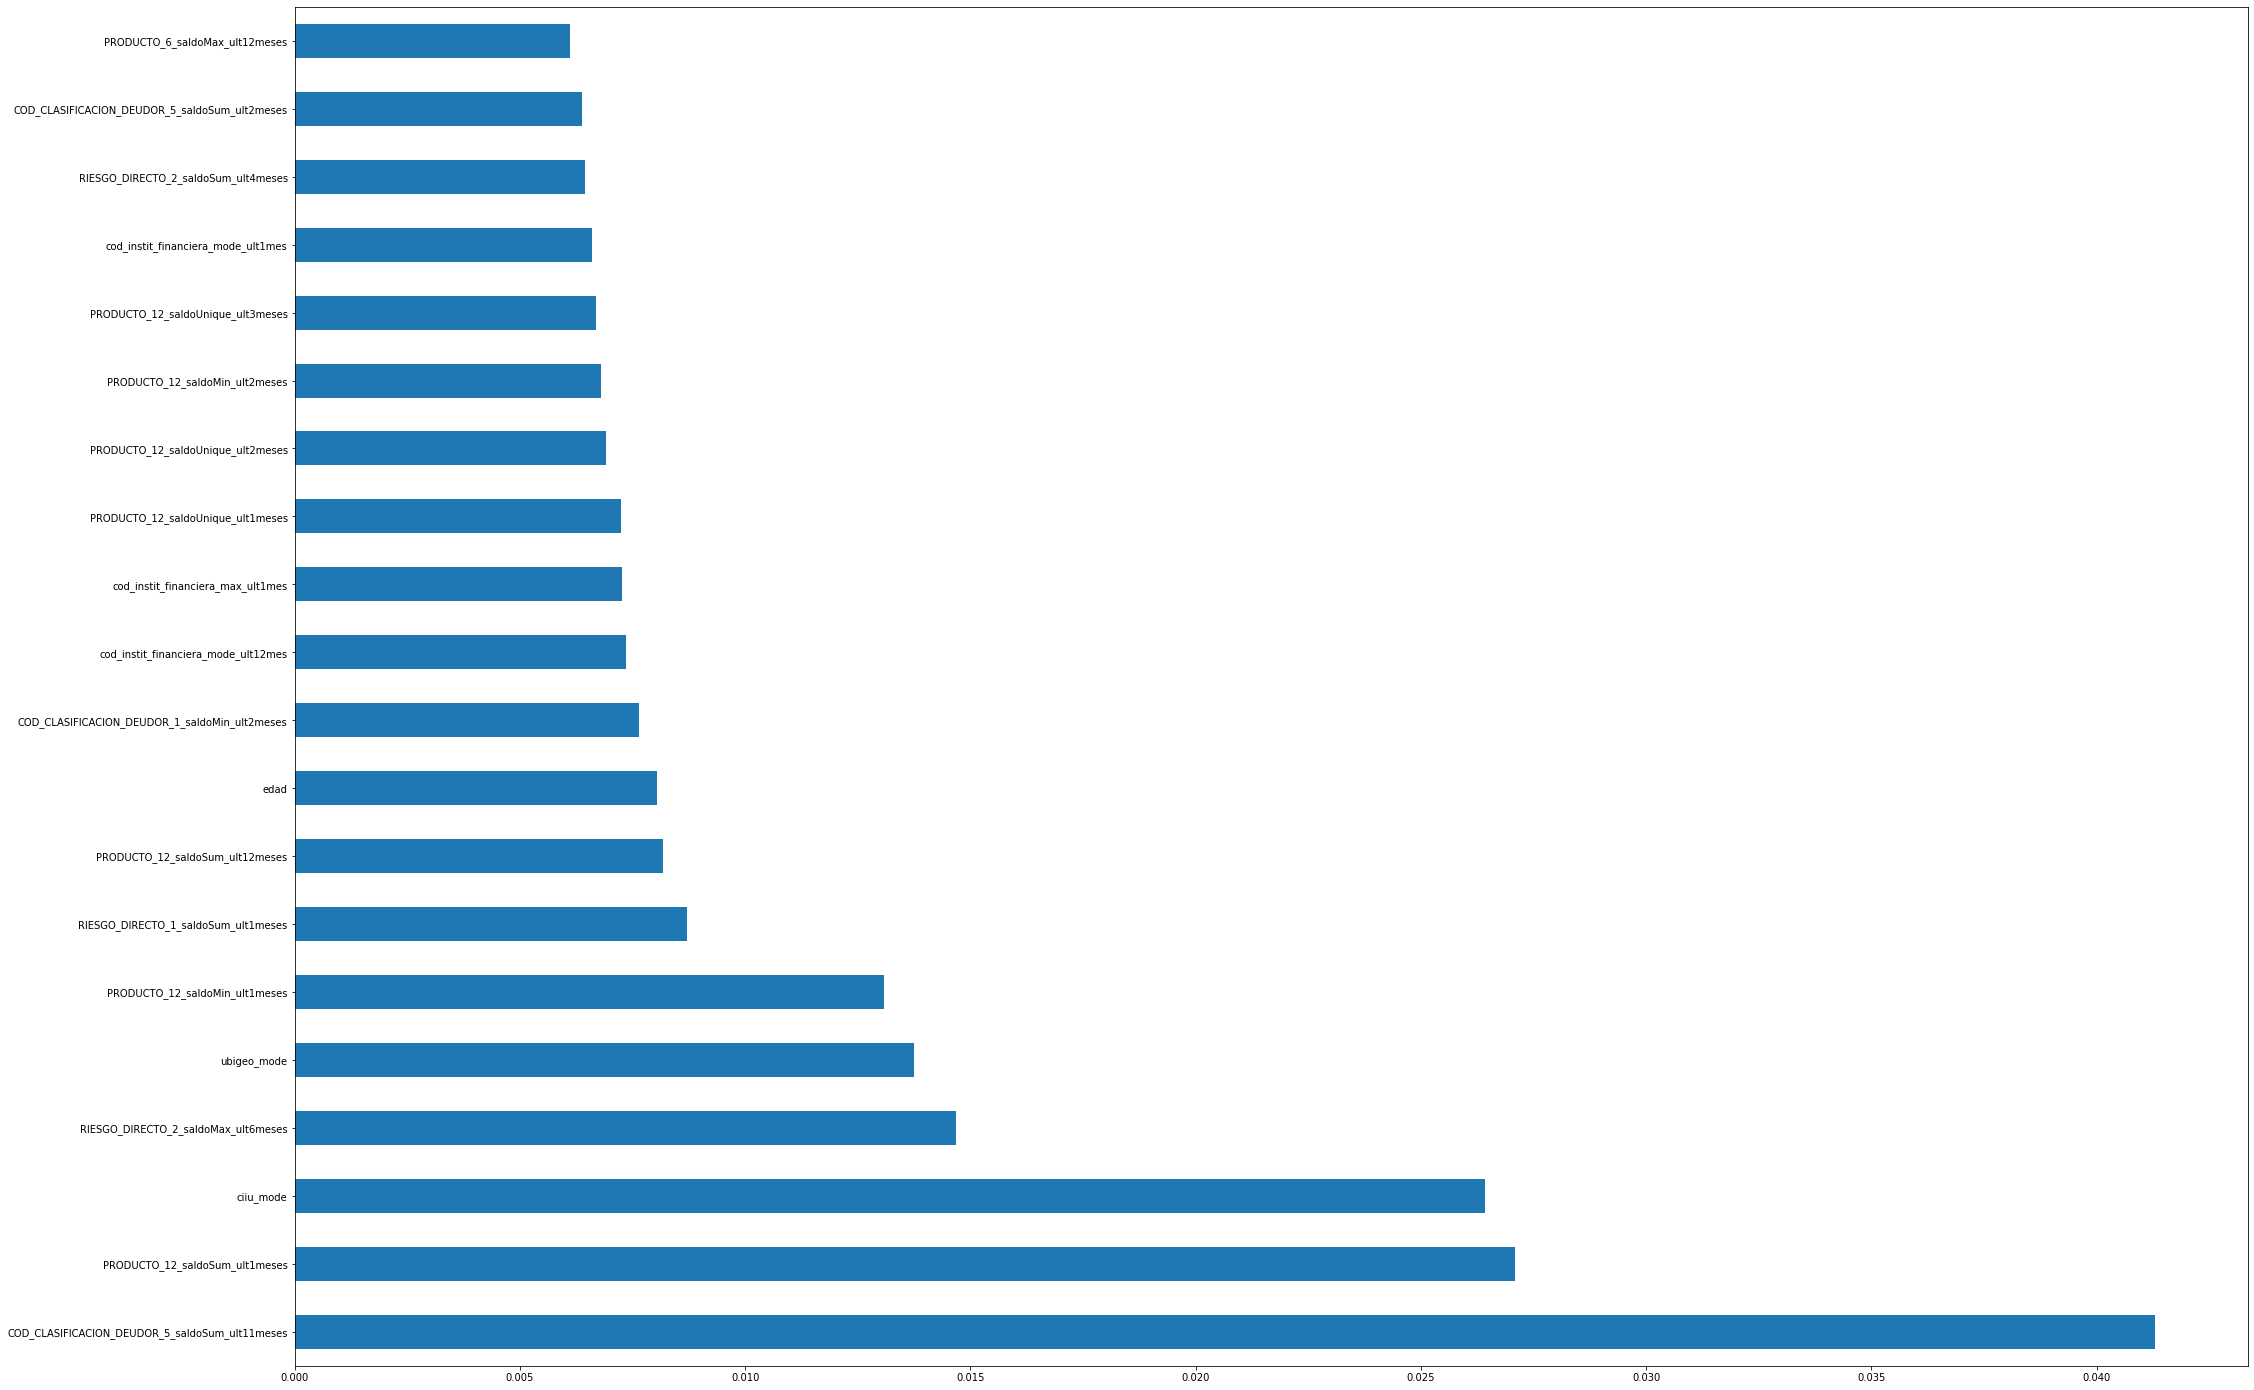

In [48]:
feat_importances_ = features_importances.mean_fi
feat_importances_.nlargest(20).plot(kind='barh', figsize=(35, 25));